In [1]:
import os
import yaml
from pprint import pprint

import pandas as pd

upDir = lambda path : os.path.join('..', path)

#class Data:
#    def __init__(self, data):
#        assert isinstance(data, dict)
#        self.__dict__ = {**self.__dict__, **data}
        

class Config:
    def __init__(self, path=None, data=None):
        if path is not None:
            with open(path) as f:
                data = yaml.full_load(f)
        assert data is not None
        self.__dict__ = {**self.__dict__, **data}
    def __repr__(self):
        return yaml.dump(self.__dict__)
                            
    
config = Config('../config.yml')

In [2]:
picklist = pd.read_csv(upDir(config.echo['picklist'][0]),
                      index_col=0)
plate_names = dict(zip(picklist['Destination Plate Name'].unique(),
                       [f'plate_{i}' for i in range(1,16)]))

picklist['dest_plate'] = [plate_names[i] for i in picklist['Destination Plate Name']]
picklist

SrcPlate    Cpd SrcWell Destination Plate Name DestWell  \
0      src racks 0..4  S1005      A1      dest racks 0..4 0       A1   
1      src racks 0..4  S1005      A1      dest racks 0..4 0       A2   
2      src racks 0..4  S1005      A1      dest racks 0..4 0       A3   
3      src racks 0..4  S1005      A1      dest racks 0..4 0       A4   
4      src racks 0..4  S1005      A1      dest racks 0..4 0       A5   
...               ...    ...     ...                    ...      ...   
4105  src racks 8..12  S4401     P21     dest racks 8..12 4      B19   
4106  src racks 8..12  S4401     P21     dest racks 8..12 4      B20   
4107  src racks 8..12  S4401     P21     dest racks 8..12 4      B21   
4108  src racks 8..12  S4401     P21     dest racks 8..12 4      B22   
4109  src racks 8..12  S4401     P21     dest racks 8..12 4      B23   

      Transfer Volume /nl dest_plate  
0                    20.0    plate_1  
1                   212.5    plate_1  
2                   605.0    plate_1  
3                  1202.5    plate_1  
4                  2000.0    plate_1  
...                   ...        ...  
4105                 20.0   plate_15  
4106                212.5   plate_15  
4107                605.0   plate_15  
4108               1202.5   plate_15  
4109               2000.0   plate_15  

[4110 rows x 7 columns]

In [3]:
_exceptions = [i for i in  config.echo['transfers'] if 'Exceptions' in i]
assert len(_exceptions) == 1
_exceptions = _exceptions[0]

exceptions = pd.read_csv(upDir(_exceptions))
src_plate_names = dict(zip(sorted(exceptions['Source Plate Name'].unique()),
                           sorted(picklist['SrcPlate'].unique()),
                          ))
dest_plate_names = dict(zip([f'Destination[{i}]' for i in range(2,17)],
                             sorted(picklist['Destination Plate Name'].unique()),
                           ))

exceptions['src_plate'] = [src_plate_names[i] for i in exceptions['Source Plate Name']]
exceptions['dest_plate'] = [dest_plate_names[i] for i in exceptions['Destination Plate Name']]
print(f'number of exceptions: {len(exceptions)}')
exceptions.head()

number of exceptions: 211


Source Plate Name  Source Plate Barcode Source Plate Type Source Well  \
0         Source[2]                   NaN       384LDV_DMSO          M1   
1         Source[2]                   NaN       384LDV_DMSO          M1   
2         Source[2]                   NaN       384LDV_DMSO          M1   
3         Source[2]                   NaN       384LDV_DMSO          C3   
4         Source[2]                   NaN       384LDV_DMSO          C3   

  Destination Plate Name  Destination Plate Barcode Destination Plate Type  \
0         Destination[2]                        NaN             384PP_Dest   
1         Destination[2]                        NaN             384PP_Dest   
2         Destination[2]                        NaN             384PP_Dest   
3         Destination[2]                        NaN             384PP_Dest   
4         Destination[2]                        NaN             384PP_Dest   

  Destination Well  Destination Well X Offset  Destination Well Y Offset  ...  \
0              B15                          0                          0  ...   
1              B14                          0                          0  ...   
2              B13                          0                          0  ...   
3              C11                          0                          0  ...   
4              C10                          0                          0  ...   

   Sample Name  Transfer Volume  Actual Volume  Current Fluid Volume  \
0          NaN            605.0            300                 1.309   
1          NaN            212.5              0                 1.309   
2          NaN             20.0              0                 1.309   
3          NaN           2000.0              0                 0.000   
4          NaN           1202.5              0                 0.000   

   Fluid Composition  Fluid Units Fluid Type  \
0             71.324      Percent       DMSO   
1             71.324      Percent       DMSO   
2             71.324      Percent       DMSO   
3              0.000      Percent       DMSO   
4              0.000      Percent       DMSO   

                                     Transfer Status       src_plate  \
0  MM0202006: Problem calc. eo fc: 1.82577 ft: 0....  src racks 0..4   
1  MM0202006: Problem calc. eo fc: 1.82577 ft: 0....  src racks 0..4   
2  MM0202006: Problem calc. eo fc: 1.82577 ft: 0....  src racks 0..4   
3  MM0202007: Problem calc. well fluid volume fc:...  src racks 0..4   
4  MM0202007: Problem calc. well fluid volume fc:...  src racks 0..4   

          dest_plate  
0  dest racks 0..4 0  
1  dest racks 0..4 0  
2  dest racks 0..4 0  
3  dest racks 0..4 0  
4  dest racks 0..4 0  

[5 rows x 21 columns]

In [4]:
def get_actual_vol(src_plate_name, 
                   dest_plate_name, 
                   well, 
                   vol):
    chunk = exceptions.loc[exceptions['src_plate'] == src_plate_name, :]
    chunk = chunk.loc[chunk['dest_plate'] == well, :]
    row = chunk.loc[chunk['Destination Well'] == well, :]
    if len(row) > 0:
        actual_vol = row['Actual Volume']
        return actual_vol
    if len(row) > 1:
        pass
    else:
        return vol
                    
a = [get_actual_vol(i,j,k,l) for i,j,k,l in zip(picklist['SrcPlate'],
                                                picklist['Destination Plate Name'],
                                                picklist['DestWell'],
                                                picklist['Transfer Volume /nl'])]
picklist['actual_vol'] = a
picklist.head()

SrcPlate    Cpd SrcWell Destination Plate Name DestWell  \
0  src racks 0..4  S1005      A1      dest racks 0..4 0       A1   
1  src racks 0..4  S1005      A1      dest racks 0..4 0       A2   
2  src racks 0..4  S1005      A1      dest racks 0..4 0       A3   
3  src racks 0..4  S1005      A1      dest racks 0..4 0       A4   
4  src racks 0..4  S1005      A1      dest racks 0..4 0       A5   

   Transfer Volume /nl dest_plate  actual_vol  
0                 20.0    plate_1        20.0  
1                212.5    plate_1       212.5  
2                605.0    plate_1       605.0  
3               1202.5    plate_1      1202.5  
4               2000.0    plate_1      2000.0

In [5]:
pwd

'/home/james/thesis-stuff/screening-fist/lab/01.0/nb'

In [6]:
import copy

from sxfst.utils import PlateData

plates = copy.deepcopy(config.platereader)
for i in plates:
    plates[i]['picklist'] = picklist.loc[picklist['dest_plate'] == i, :]
    plates[i]['test']['data'] = PlateData(upDir(plates[i]['test']['path']))
    plates[i]['control']['data'] = PlateData(upDir(plates[i]['control']['path']))
    
pprint(plates['plate_1'])

{'control': {'data': .././platereader/22042022,131152_220425103858.CSV
User: USER,Path: C:\Program Files (x86)\BMG\CLARIOstar\User\Data\,Test run no.: 2870

 1  2  3  4  5  6  7  8  9  10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
A :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  : 
B :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  : 
C :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  : 
D :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  : 
E :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  : 
F :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  : 
G :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  : 
H :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  : 
I :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  : 
J :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  :  : 
K :  :  :  :  :  :  :  :  :  :

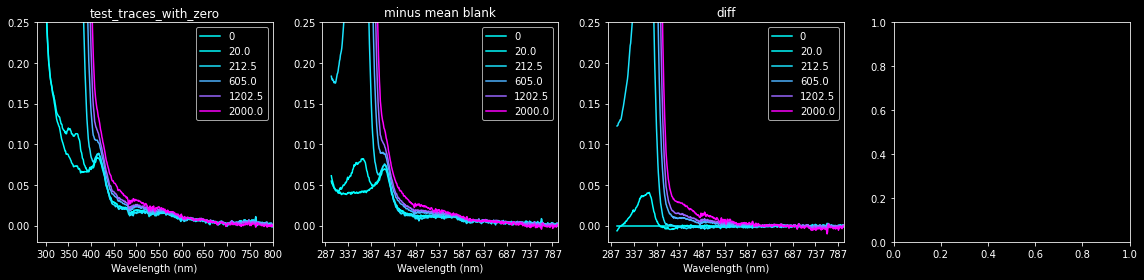

In [153]:
from tqdm import tqdm                                                      
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('dark_background')
COLOR = 'white'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

def plot_set(*data, 
             labels=None,
             vols=None,
             titles=None,
             axs=[],
            ):                                                 
    assert len(data) > 0, 'empty set given'                                   
    if titles is None:
        titles = [None] * len(data)
    elif isinstance(titles, str):
        titles = [titles]*len(data)
    assert len(titles) == len(data), f'N titles({len(titles)}) != N plots ({len(data)})'
    n_plots = len(data) + len(axs)
    if n_plots < 8:                                                         
        fig, ax = plt.subplots(1, 
                               len(data) + len(axs),                                     
                               figsize=(4*n_plots,4))                                 
    else:                                                                      
        fig, ax = plt.subplots(n_plots//(nRows:=8),                         
                               nRows,                                          
                               figsize=(16,128*(len(data) / len(data))))     
                                                                               
    for plot_num, (wells, ax_, title) in enumerate(zip(data, ax.flatten(), titles)):                                  
        if vols is None:
            vols = range(len(wells))
        for row_, vol in zip(wells.index, vols):                                 
            ax_.plot(wells.loc[row_,:], 
                     c=plt.cm.cool(vol/2000),
                     label=vol)
                                                                               
        ax_.set_xlim(280,800)                                                  
        ax_.set_ylim(-0.02,0.25)                                                  
        ax_.set_title(title)                                                     
        ax_.set_xticks(wells.columns[::50])
        ax_.set_xlabel('Wavelength (nm)')                                      
        #ax_.axis('off')                                                        
        ax_.legend()
    if len(axs) > 0:
        for i,j in enumerate(axs, plot_num):
            ax_ = ax.flatten()[i]
            ax_ = j
                                                                               
    #plt.title(title)                                                           
    plt.tight_layout()                     
    plt.show()
    
    

plot_set(test_traces_with_zero, 
         (a:=test_traces_with_zero - blanks_mean),
         (b:=a - a.iloc[0,:]),
         vols=vols,
         titles=['test_traces_with_zero', 
                 'minus mean blank',
                 'diff',
                ],
         axs=[xy],
         )

In [154]:
from scipy.ndimage import gaussian_filter1d

def norm_traces(test, 
                ctrl=None):
    test = test.subtract(test.loc[:,800],
                         axis=0)
    if ctrl is not None:
        ctrl = ctrl.subtract(ctrl.loc[:,800],
                             axis=0)
        norm = test - ctrl
        return norm
    else:
        return test

def smooth(df,
           sigma=3,
           axis=-1,
           ):
    cols = df.columns
    idx = df.index
    smth = pd.DataFrame(gaussian_filter1d(df, sigma, axis=axis),
                        index=idx,
                        columns=cols)
    return df

def is_anomaly(norm):
    return False

def diff(norm, baseline):
    return norm.subtract(baseline,
                         axis=0)

def response(_diff):
    a420 = _diff.loc[:,420]
    a390 = _diff.loc[:,390]
    return a420.abs().add(a390.abs())

def c2(v1, c1, v2):
    return (v1 * c1) / v2

def proc(cpd, # Cpd()
         sigma=3,
         ):
    name = cpd.name
    test = cpd.test
    ctrl = cpd.ctrl
    echo_map = cpd.echo_map
    norm = norm_traces(test, ctrl)
    smth = smooth(norm, sigma)
    if not is_anomaly(smth):
        change = diff(smth, smth[list(smth.keys())[0]])
        y = dict(response(change))
        #print(y)
        vol_well_map = dict(zip(echo_map['DestWell'],
                                echo_map['Transfer Volume /nl']))
        x = {i:c2(v1=vol_well_map[i] * 1e-9,    # nl to l
                  c1=10e-3,                     # 10 mM stock
                  v2=40e-6,                     # 40 ul well vol
                  ) / 1e-6                     # M to uM
              for i in vol_well_map}
        print(x)
        print(y)


In [165]:
a.loc[:,390]

0.0       0.04575
20.0      0.04850
212.5     0.12250
605.0     0.31850
1202.5    0.63150
2000.0    1.03050
Name: 390, dtype: float64

  0%|          | 0/64 [00:00<?, ?it/s]

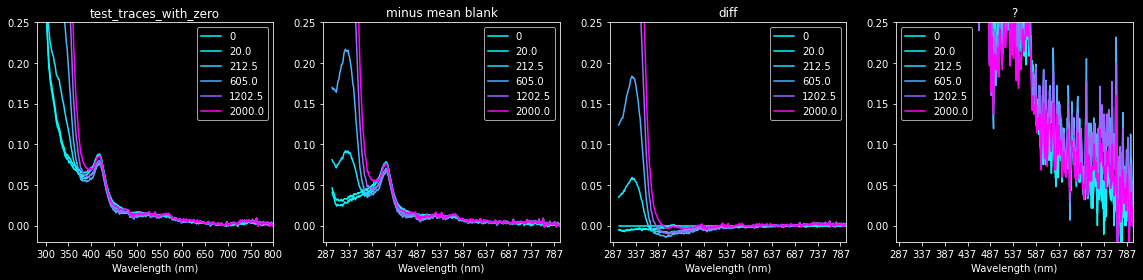

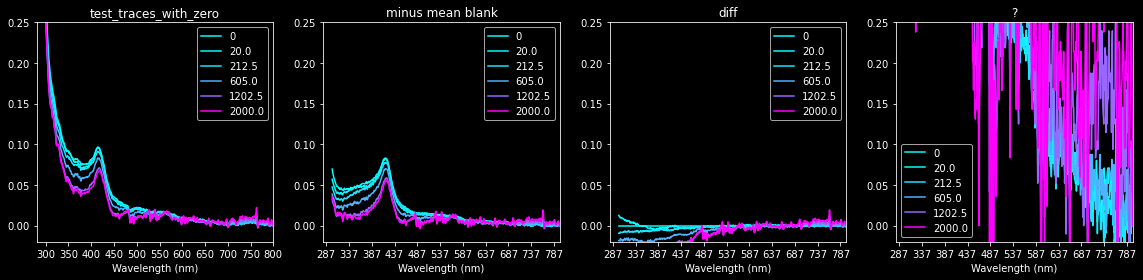

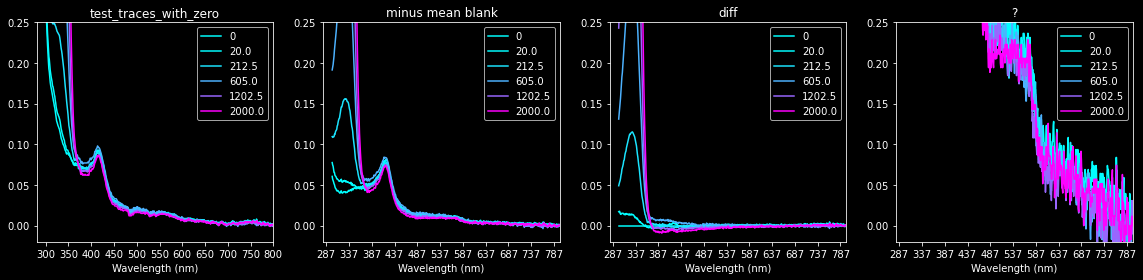

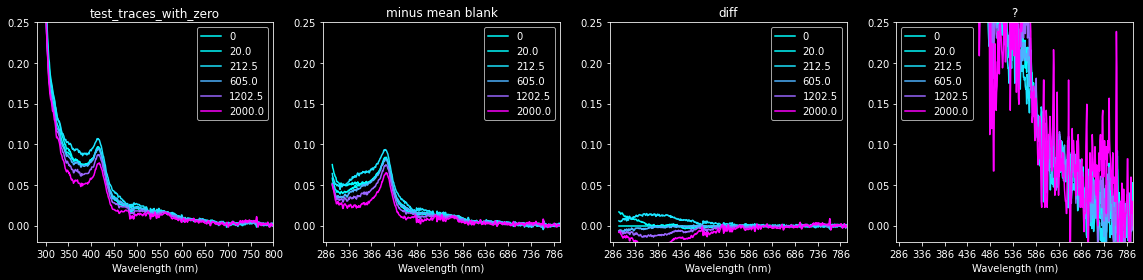

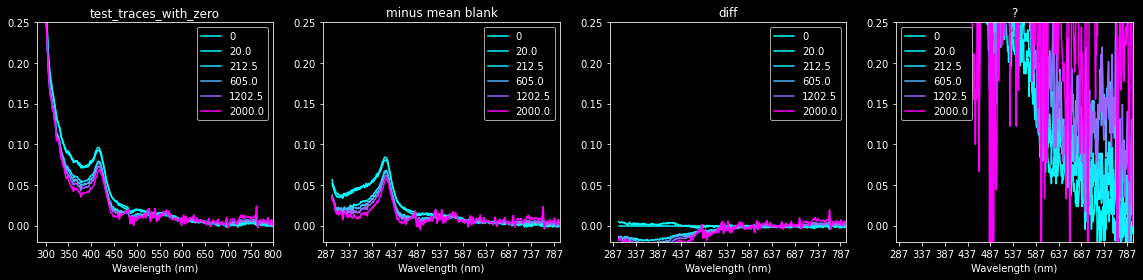

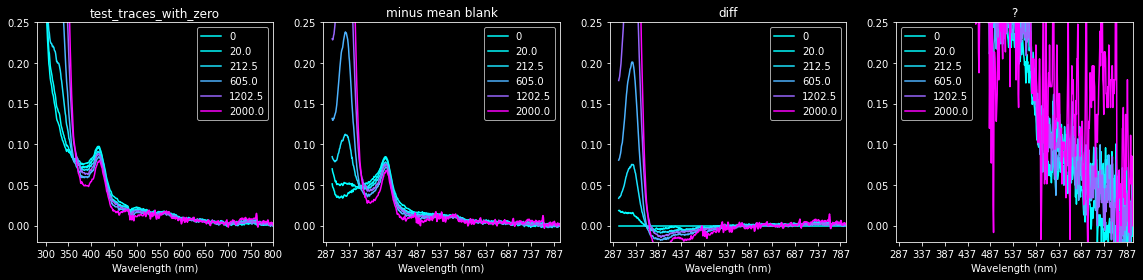

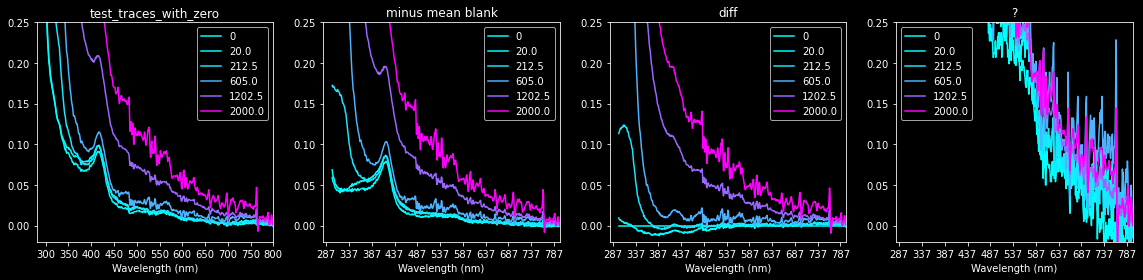

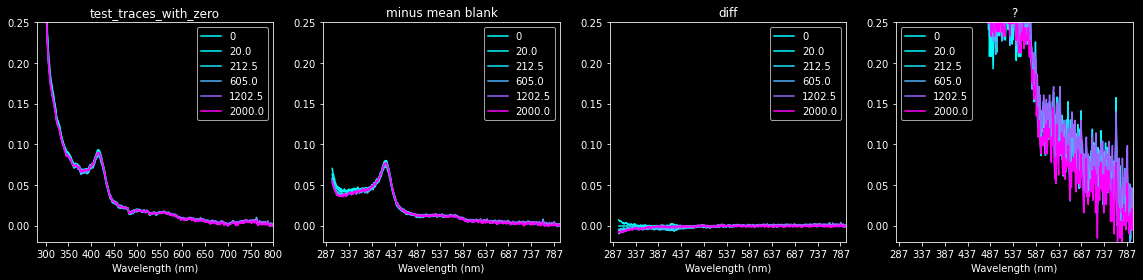

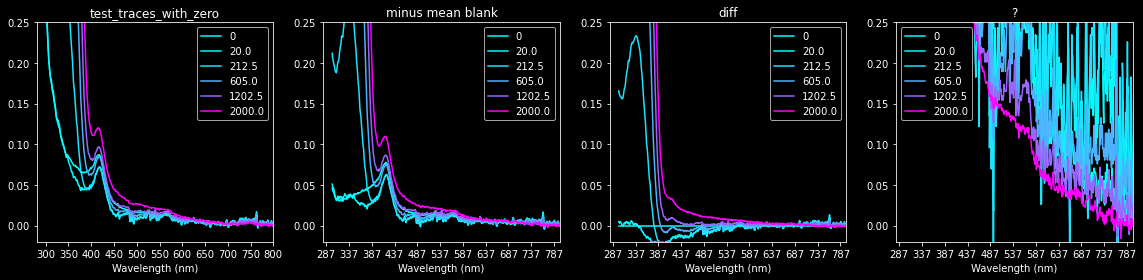

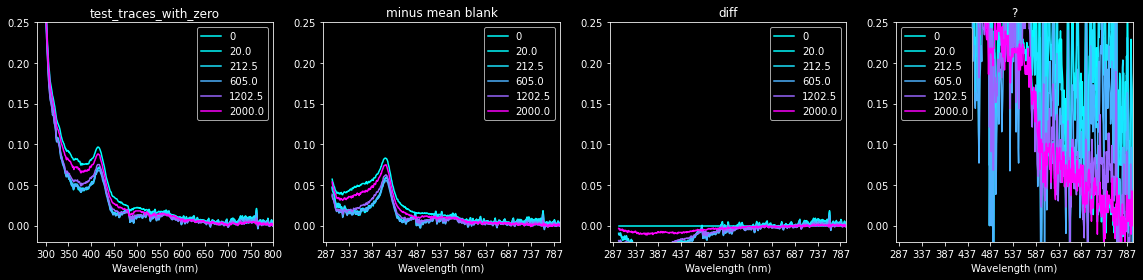

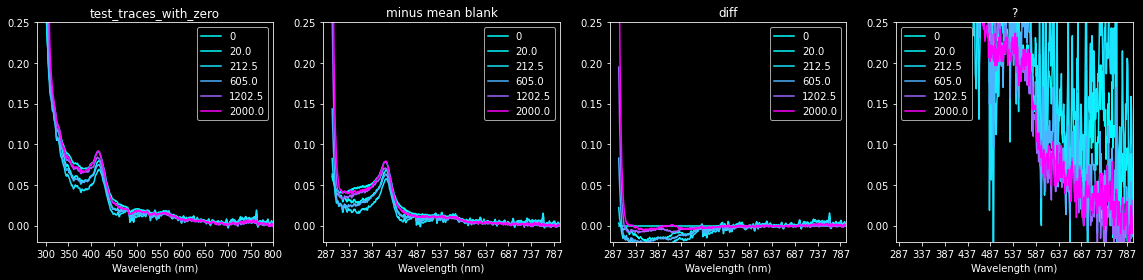

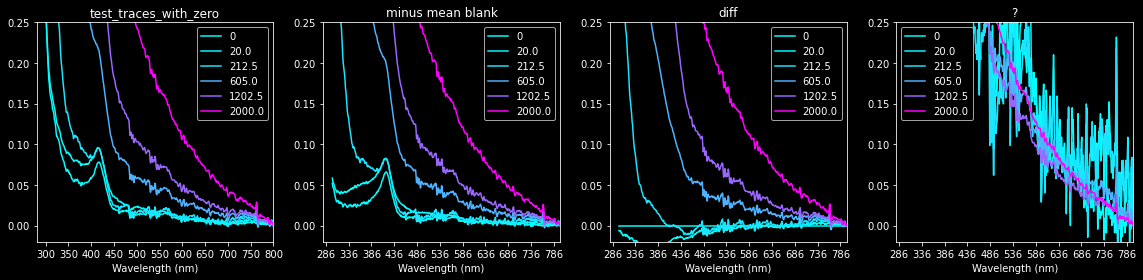

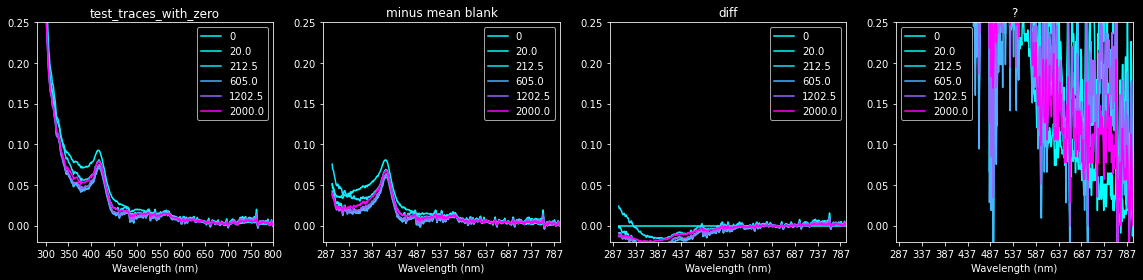

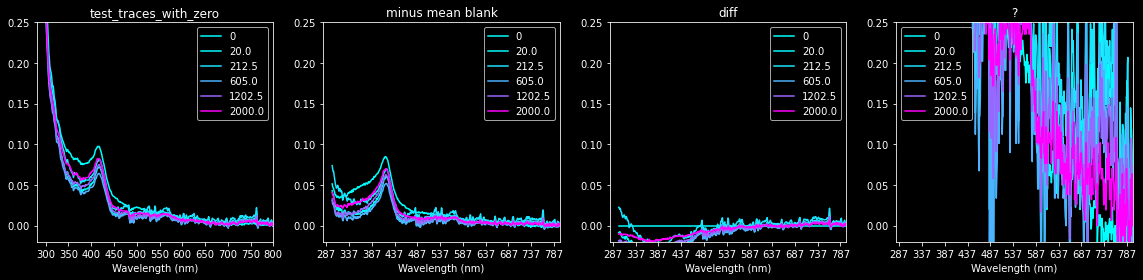

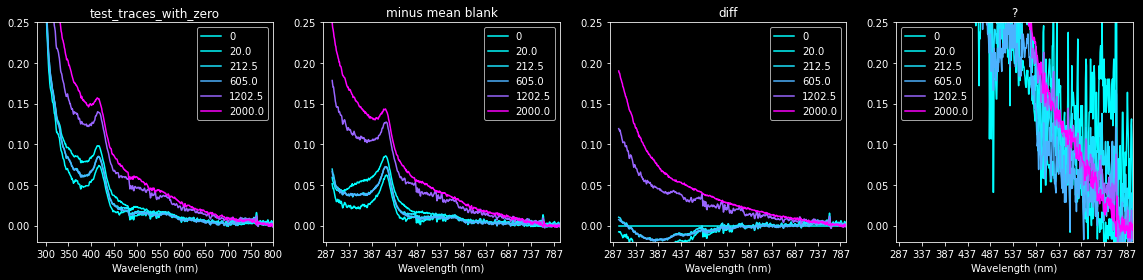

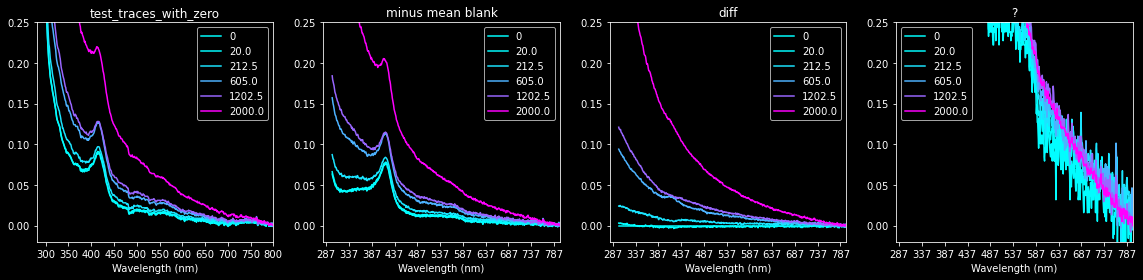

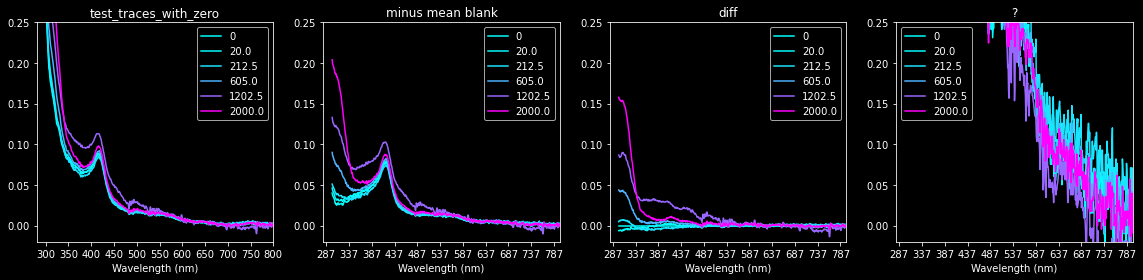

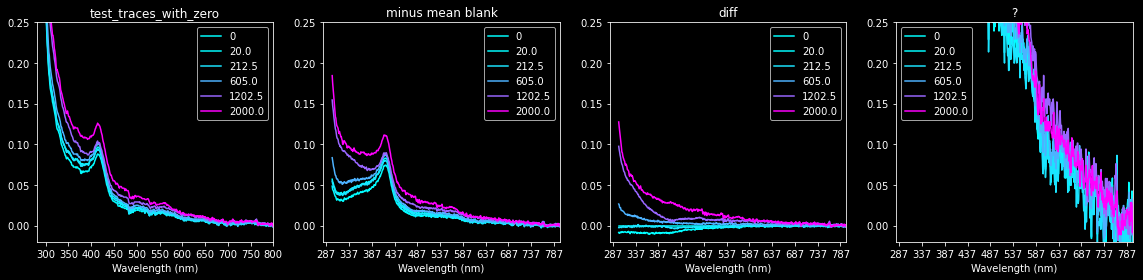

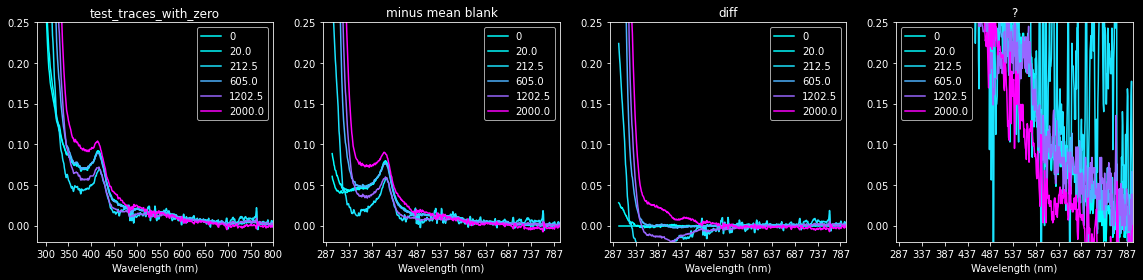

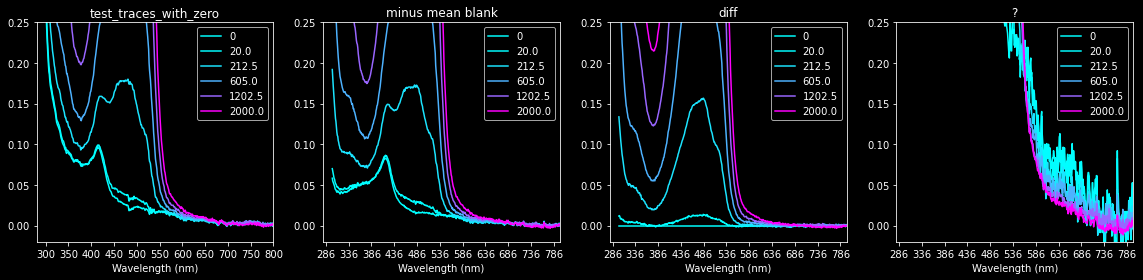

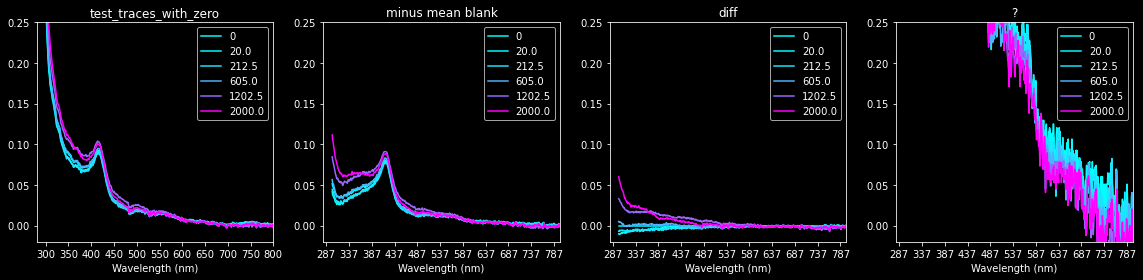

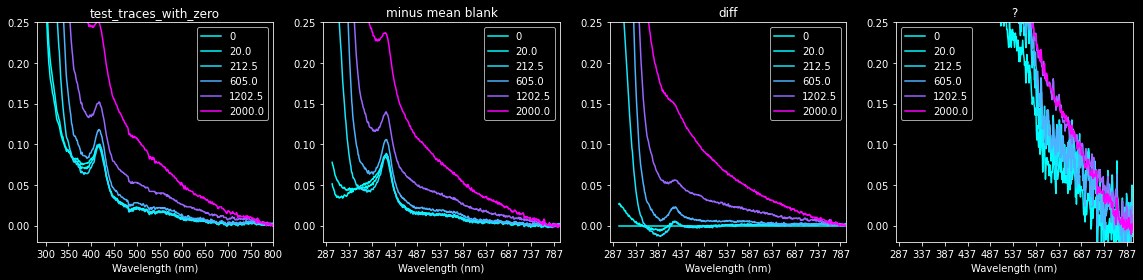

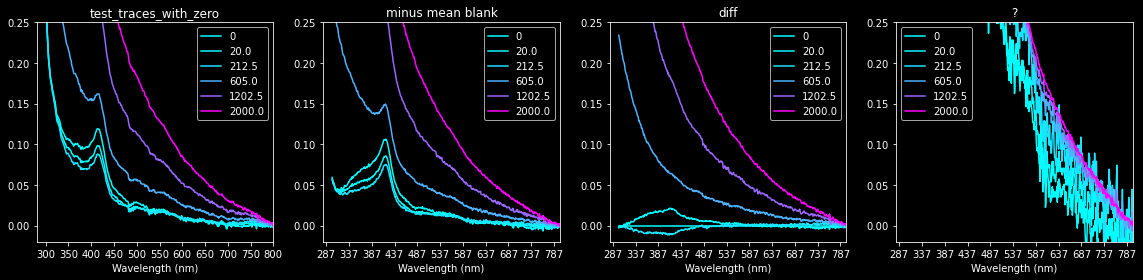

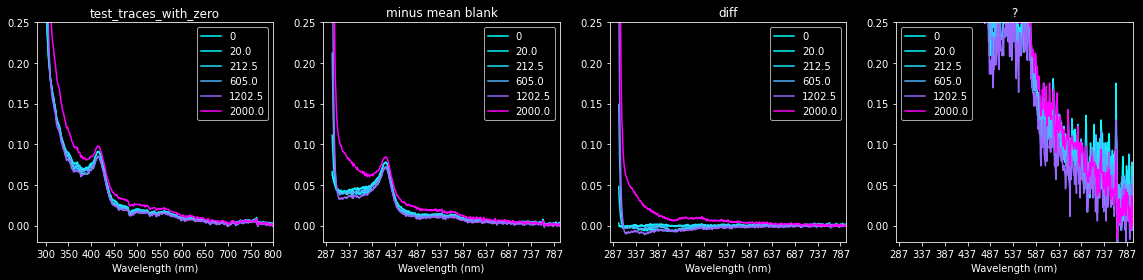

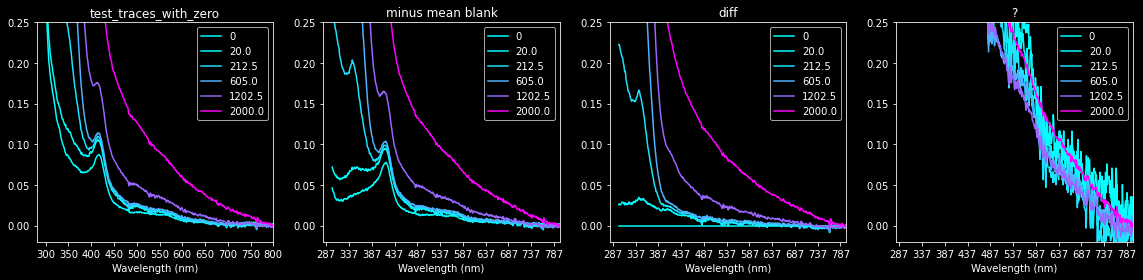

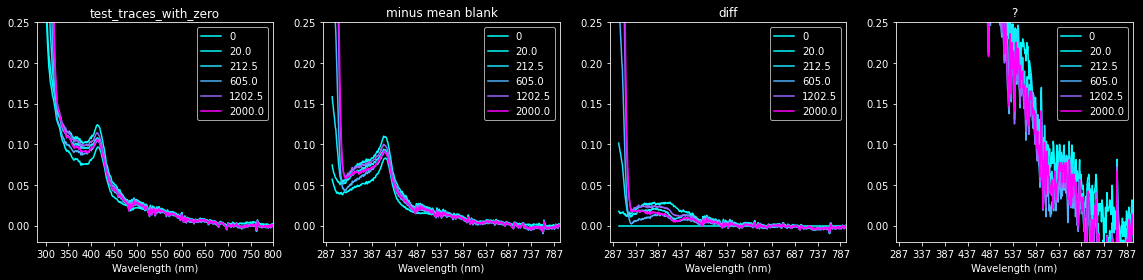

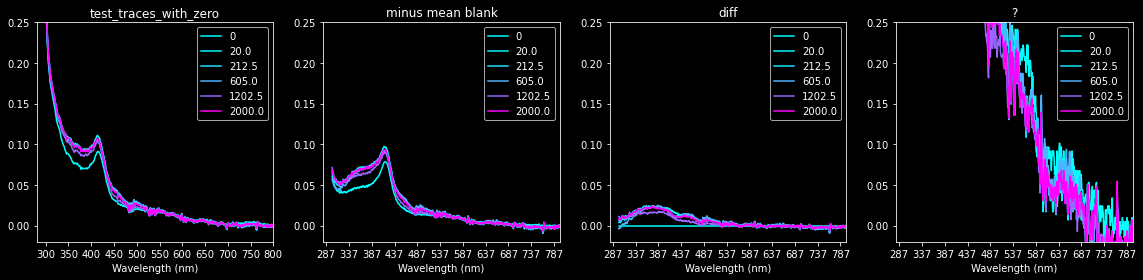

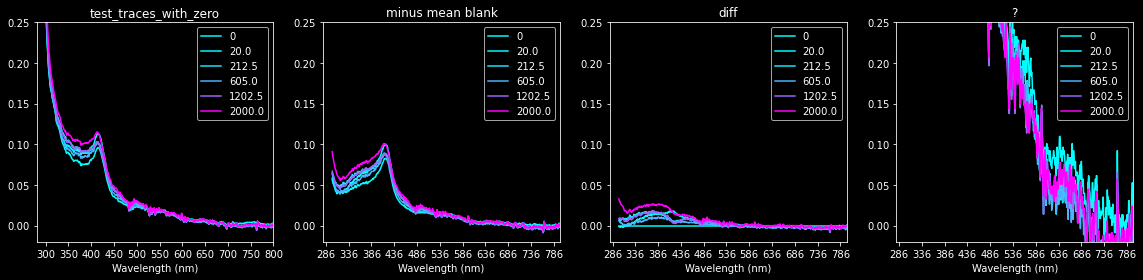

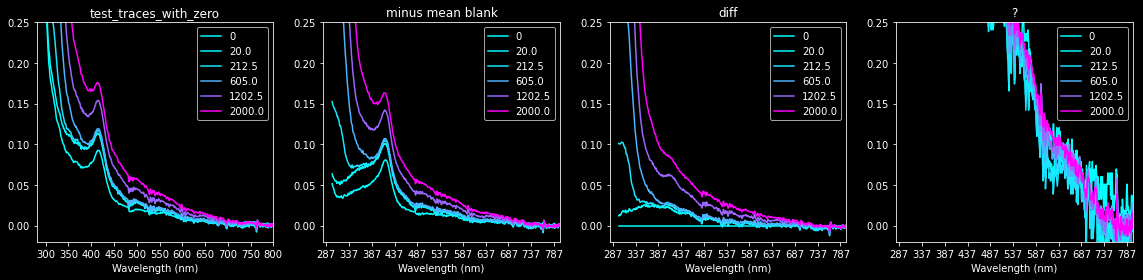

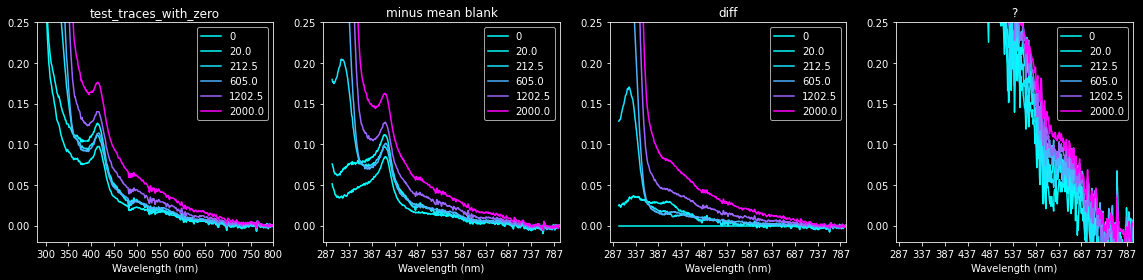

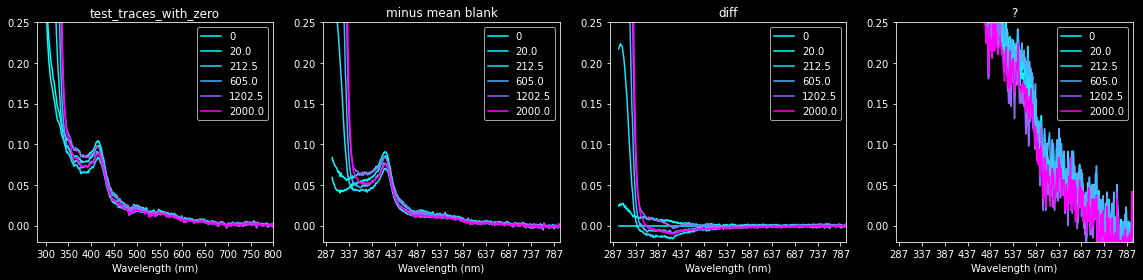

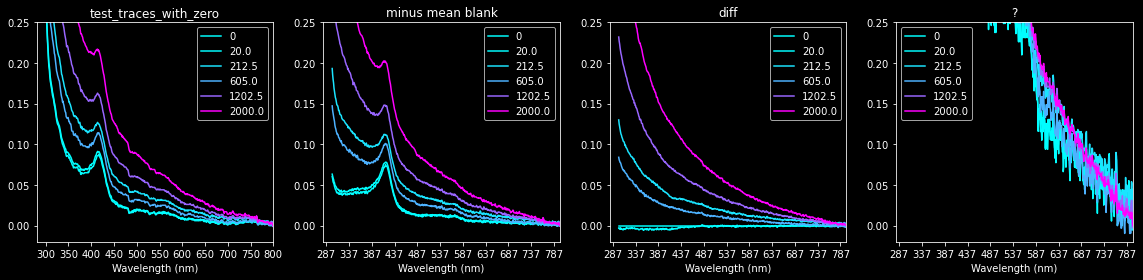

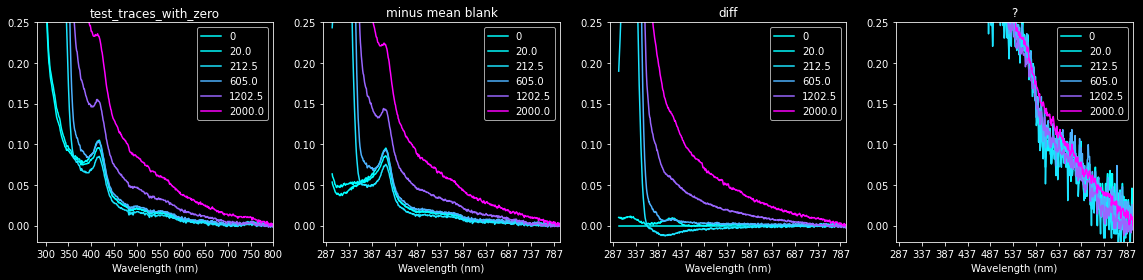

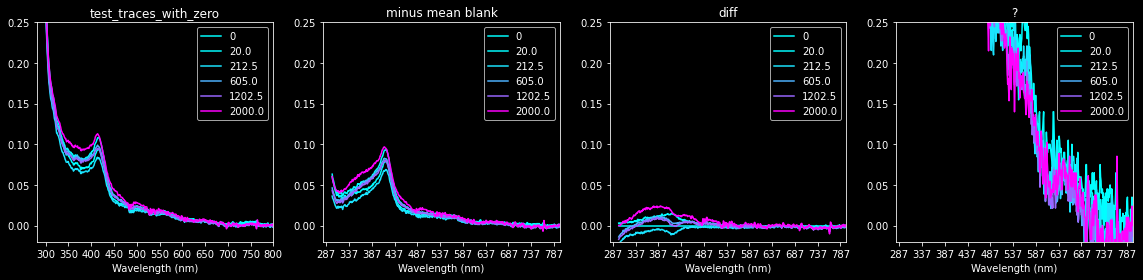

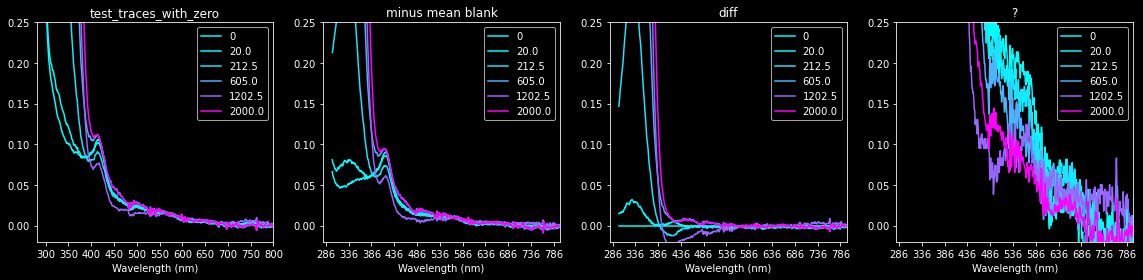

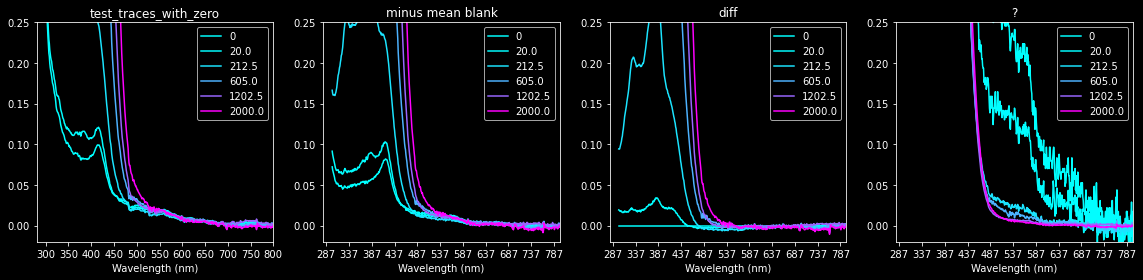

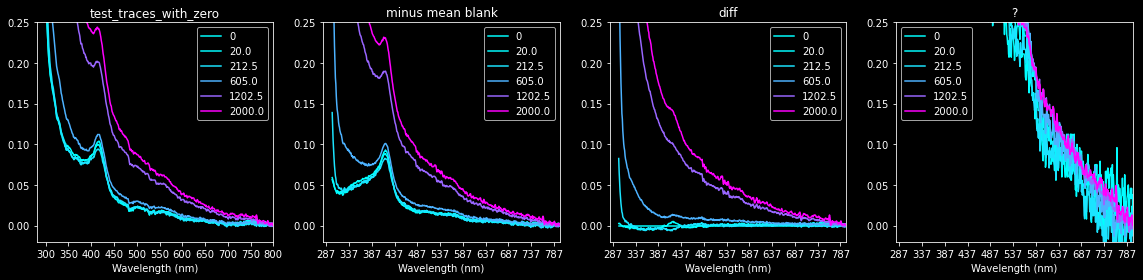

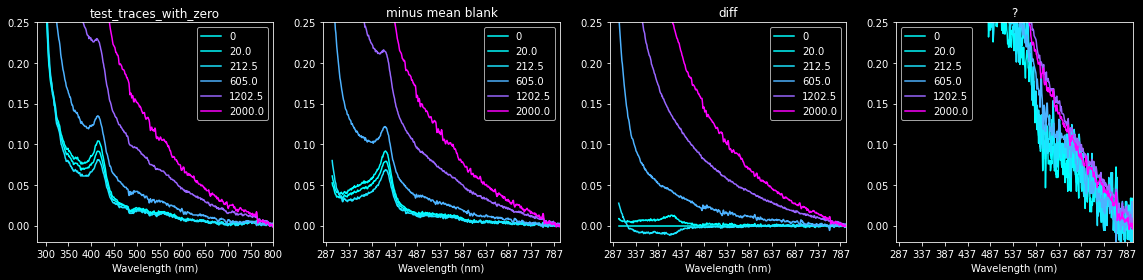

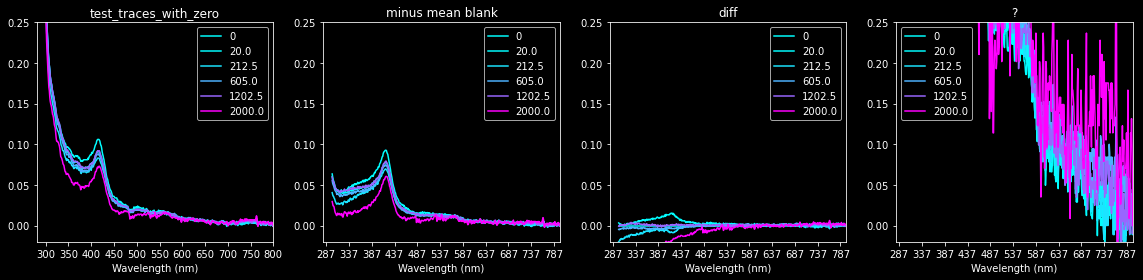

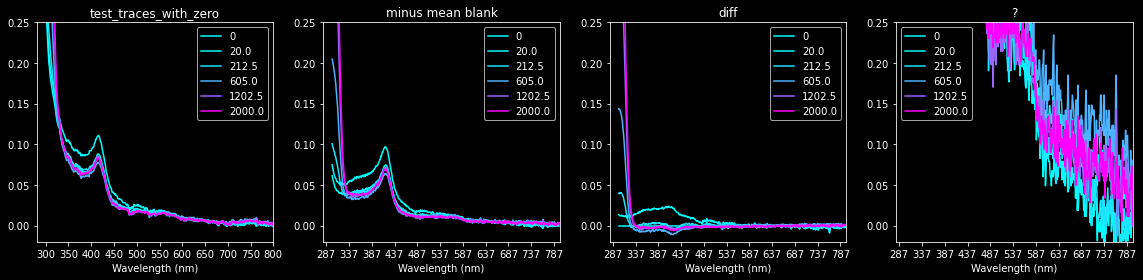

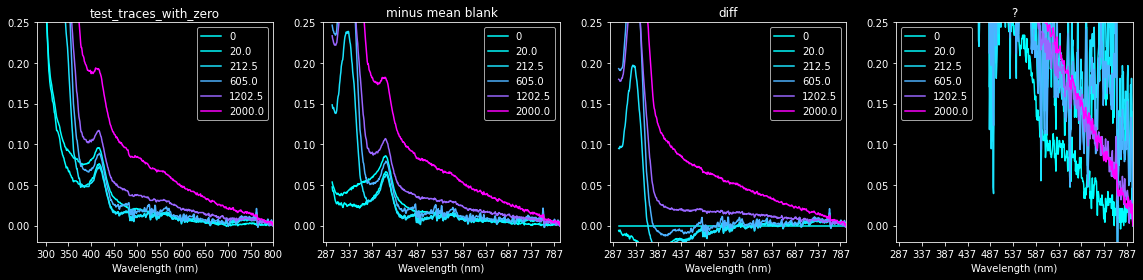

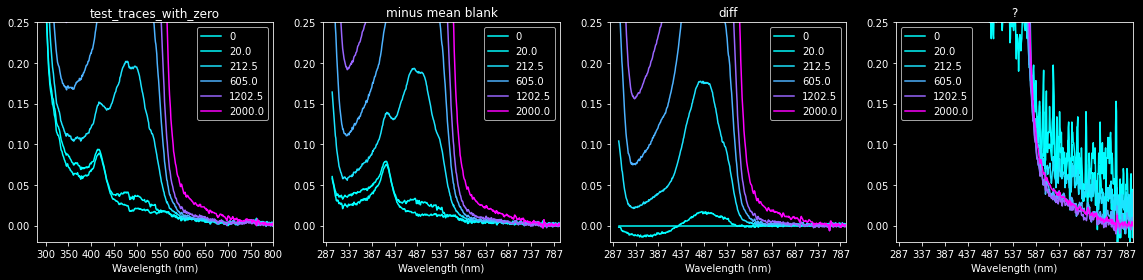

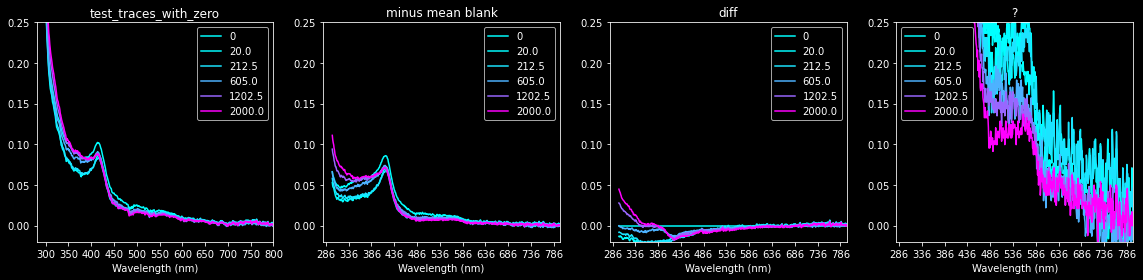

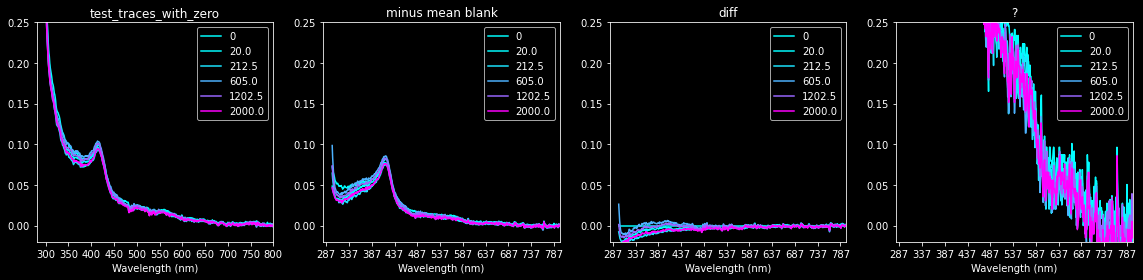

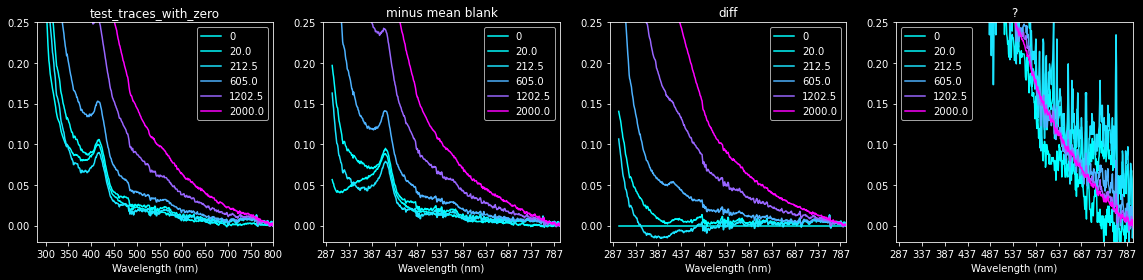

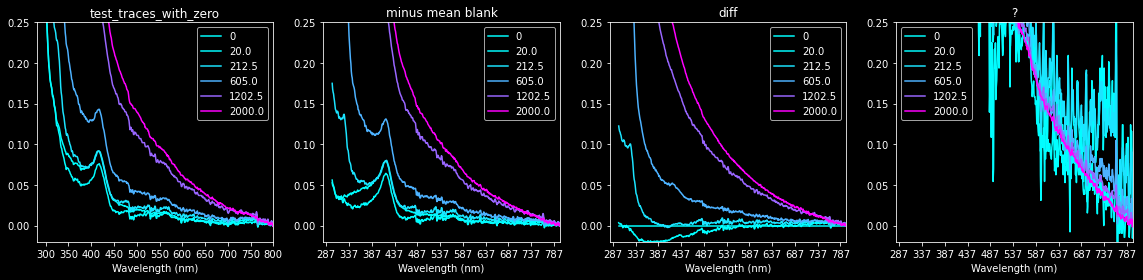

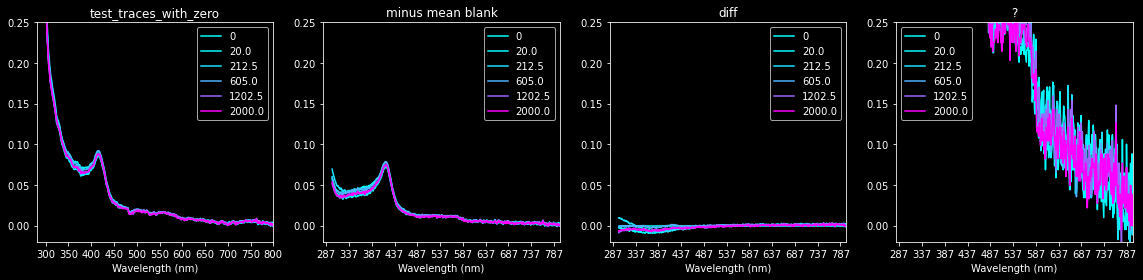

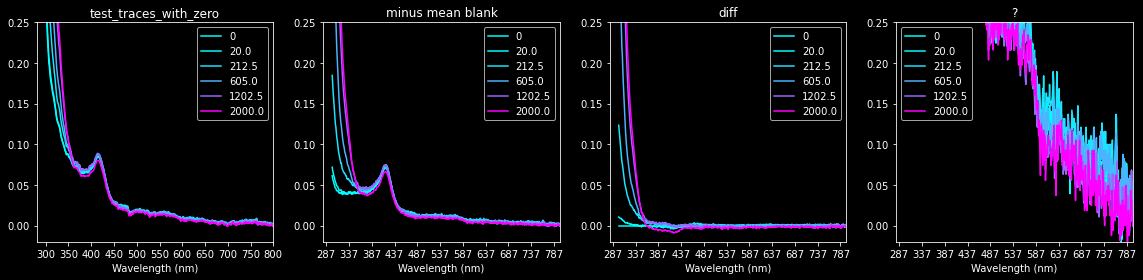

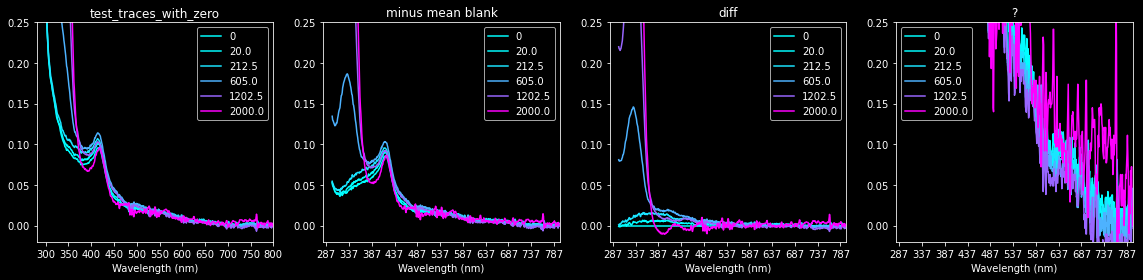

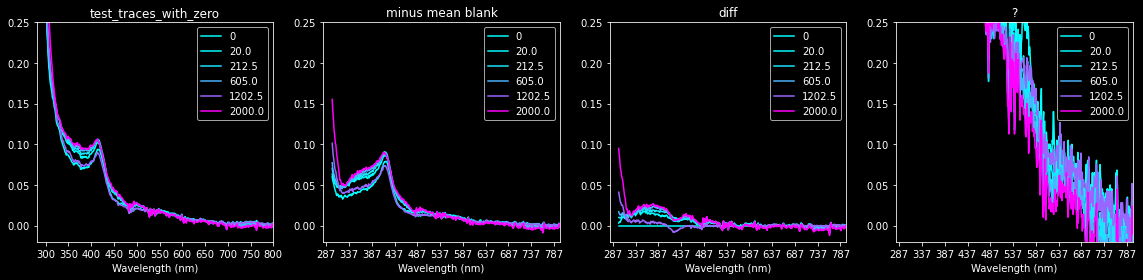

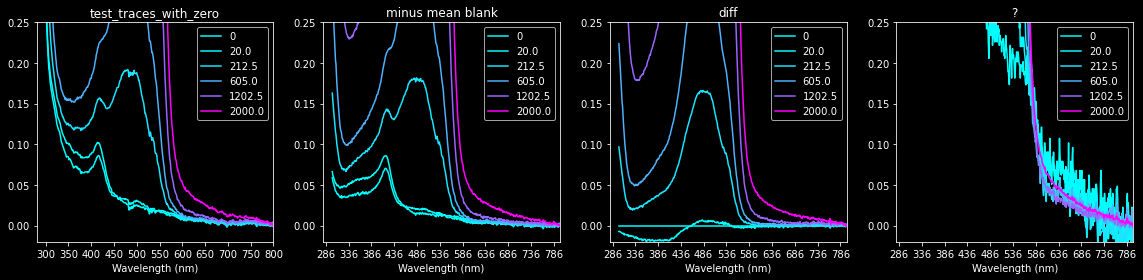

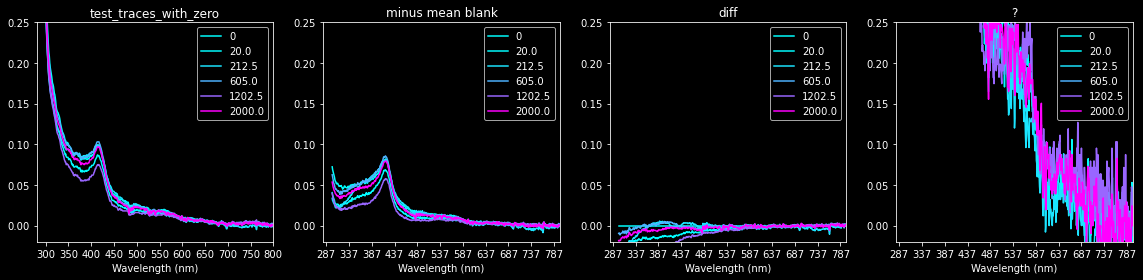

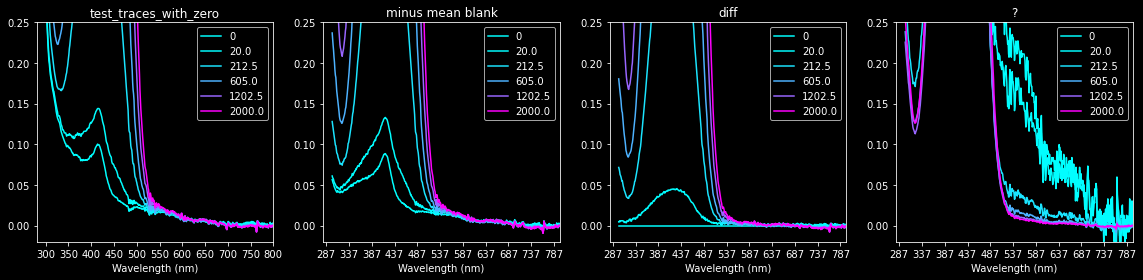

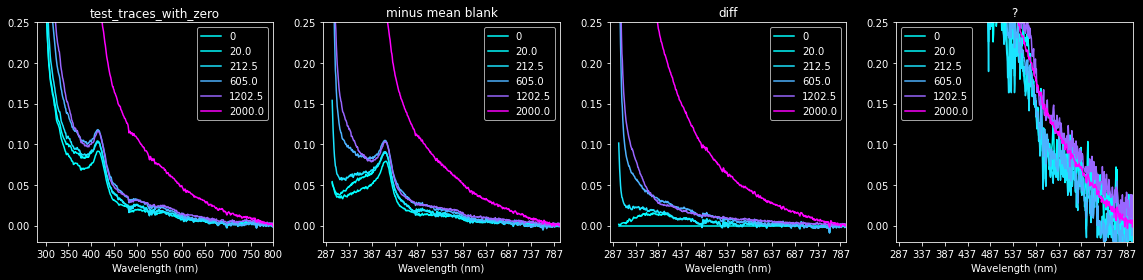

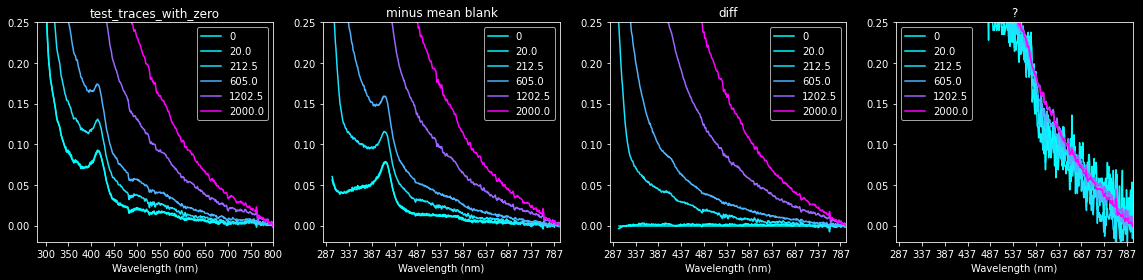

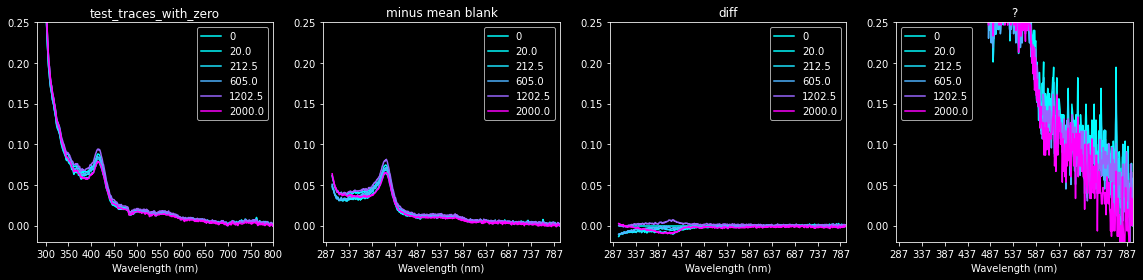

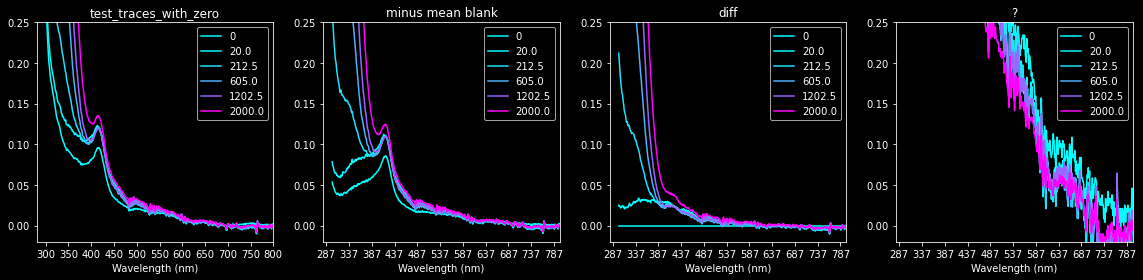

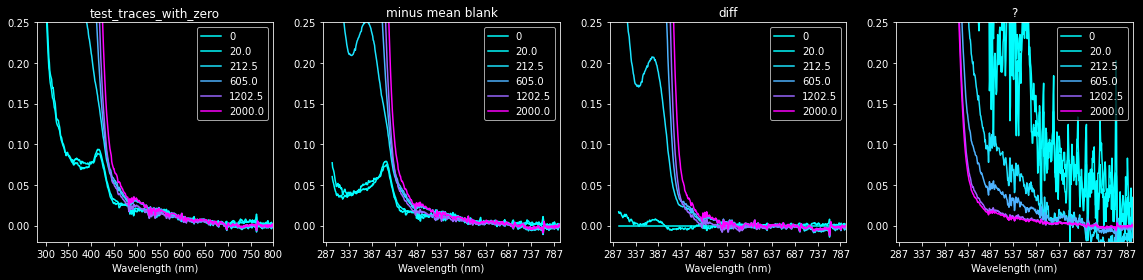

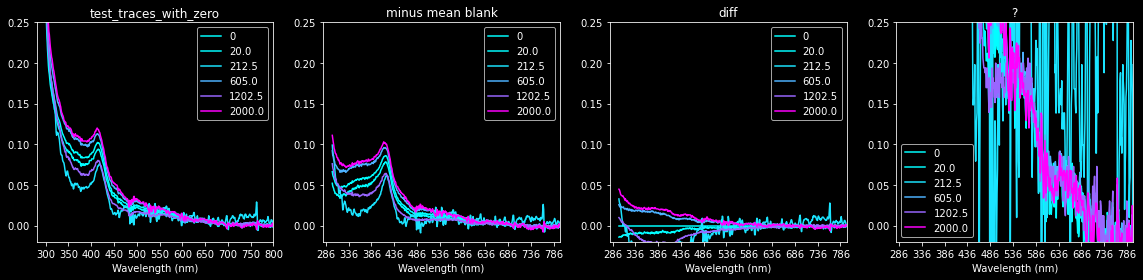

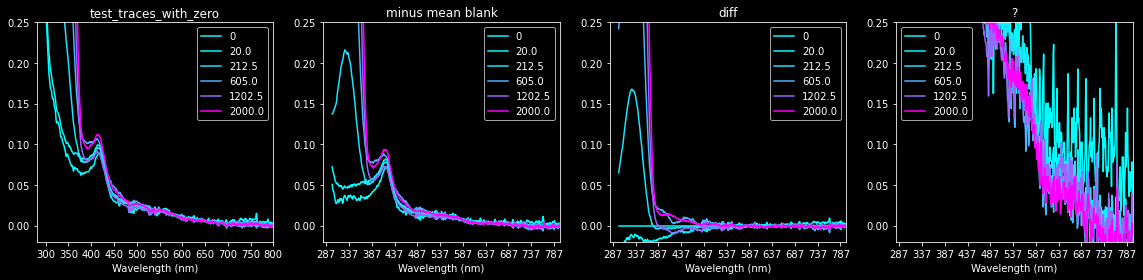

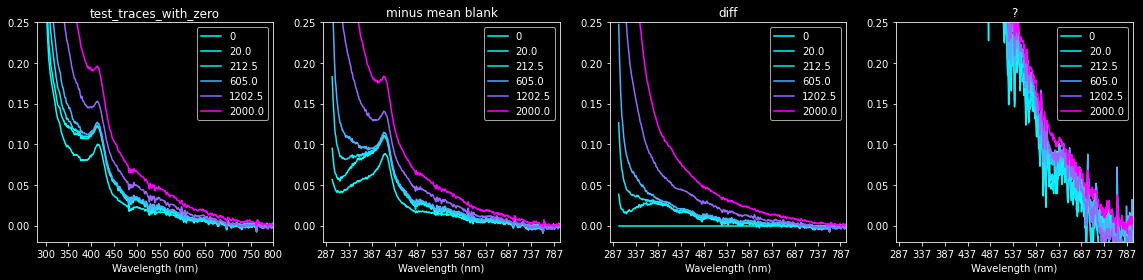

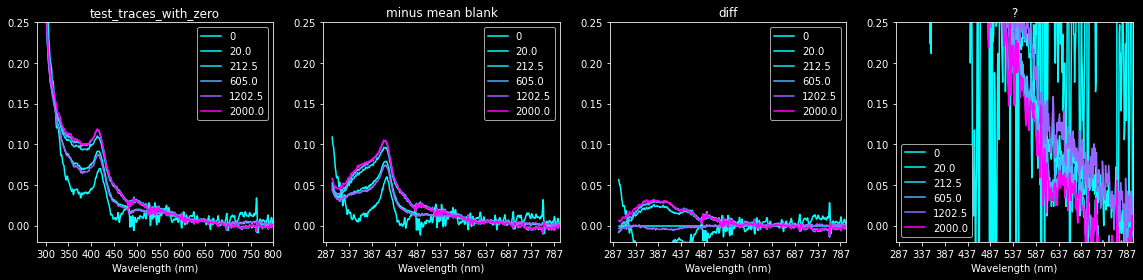

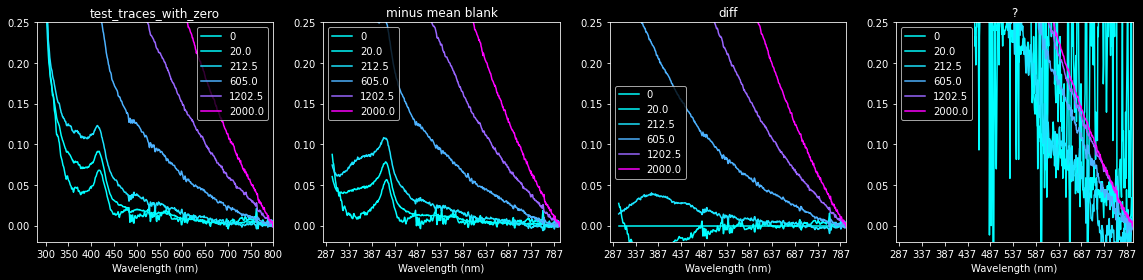

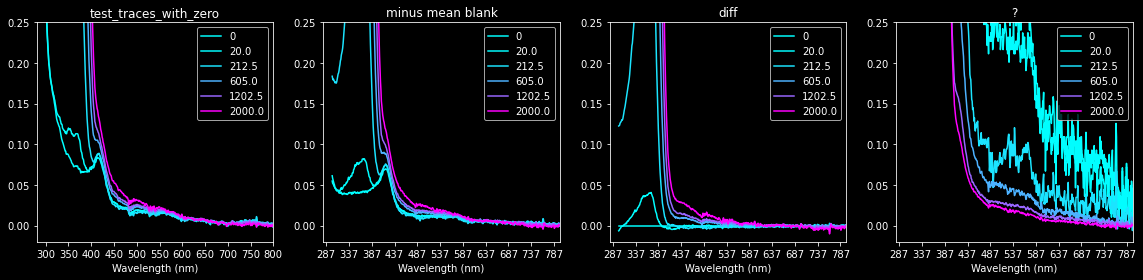

In [167]:
    from tqdm.notebook import tqdm

    plate_1 = plates['plate_1']
    pck_1 = plate_1['picklist']
    no_cpd = [i for i in plate_1['control']['data'].df.index \
                 if i not in pck_1['DestWell'].to_list()]

    sigma = 1/32

    for i in tqdm(pck_1['Cpd'].unique()):
        pck_chunk = pck_1.loc[pck_1['Cpd'] == i, :]
        cpd_name = pck_chunk['Cpd'].unique()[0]

        ctrl_wells_raw = plate_1['control']['data'][pck_chunk['DestWell'].to_list()]
        test_wells_raw = plate_1['test']['data'][pck_chunk['DestWell'].to_list()]

        #test_wells_clipped = test_wells_raw.where(test_wells_raw < 1).dropna(axis=1)
        #ctrl_wells_clipped = ctrl_wells_raw.where(ctrl_wells_raw < 1).dropna(axis=1)

        test_wells_clipped = test_wells_raw.loc[:,300:800]
        ctrl_wells_clipped = ctrl_wells_raw.loc[:,300:800]

        test_wells_smooth = smooth(test_wells_clipped, sigma=sigma)
        ctrl_wells_smooth = smooth(ctrl_wells_clipped, sigma=sigma)

        test_wells_norm = norm_traces(test_wells_clipped)
        ctrl_wells_norm = norm_traces(ctrl_wells_clipped)

        #ctrl_wells = norm_traces(smooth(ctrl_wells_clipped, sigma=sigma))
        #test_wells = test_wells.where(test_wells < 1).dropna(axis=1)
        #ctrl_wells = ctrl_wells.where(ctrl_wells < 1).dropna(axis=1)

        ctrl_plate_row = set([i[0] for i in ctrl_wells_raw.index.to_list() + ctrl_wells_raw.index.to_list()])
        assert len(ctrl_plate_row) == 1
        ctrl_plate_row = list(ctrl_plate_row)[0]
        _blanks =  [i for i in no_cpd if ctrl_plate_row in i]
        blanks_raw = norm_traces(smooth(plate_1['control']['data'][_blanks], 
                                        sigma=sigma))
        blanks_clipped = blanks_raw.where(blanks_raw < 1).dropna(axis=1)
        blanks_mean =  blanks_clipped.mean(axis=0)

        test_plate_row = set([i[0] for i in test_wells_raw.index.to_list() + ctrl_wells_raw.index.to_list()])
        assert len(test_plate_row) == 1
        test_plate_row = list(test_plate_row)[0]
        _prots =  [i for i in no_cpd if test_plate_row in i]
        prots_raw = norm_traces(smooth(plate_1['test']['data'][_prots], 
                                       sigma=sigma))
        prots_clipped = prots_raw.where(prots_raw < 1).dropna(axis=1)
        prots_mean = prots_clipped.mean(axis=0)

        test_minus_ctrl_norm = test_wells_norm - ctrl_wells_norm
        test_traces_with_zero =  pd.concat([prots_mean, test_wells_norm.T], axis=1).T
        ctrl_traces_with_zero =  pd.concat([blanks_mean, ctrl_wells_norm.T], axis=1).T

        vols = [0] + list(pck_chunk['actual_vol']) # match up logs
        test_traces_with_zero.index = vols
        ctrl_traces_with_zero.index = vols
        #test_traces = prots_mean.append(test_wells_norm)
        #test_traces_ = prots_mean.append(test_minus_ctrl_norm)
        #plot_set(test_wells_raw, 
        #         test_wells_clipped, 
        #         test_wells_smooth,
        #         test_wells_norm,
        #         vols=pck_chunk['actual_vol'])
        #plot_set(ctrl_wells_raw, 
        #         ctrl_wells_clipped, 
        #         ctrl_wells_smooth,
        #         ctrl_wells_norm,
        #         vols=pck_chunk['actual_vol'])
        plot_set(test_traces_with_zero, 
                 (a:=test_traces_with_zero - blanks_mean),
                 (b:=a - a.iloc[0,:]),
                 a.div(a.loc[:,390], axis=0),
                 vols=vols,
                 titles=['test_traces_with_zero', 
                         'minus mean blank',
                         'diff',
                         '?',
                        ],
                 )
        #plot_set(test_wells_norm, 
        #         ctrl_wells_norm, 
        #         test_wells - ctrl_wells,
        #         diff(test_wells, prots.mean(axis=0)),
        #         vols=pck_chunk['actual_vol'])

In [89]:
a - a.iloc[0,:]

287  288  289  290  291  292  293  294  295  296  ...      791  \
0.0     NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  0.00000   
20.0    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  0.00025   
212.5   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  0.00025   
605.0   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ... -0.00075   
1202.5  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ... -0.00075   
2000.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ... -0.00075   

            792           793     794     795      796     797     798  \
0.0     0.00000  0.000000e+00  0.0000  0.0000  0.00000  0.0000  0.0000   
20.0   -0.00075  8.673617e-19  0.0015  0.0015 -0.00025 -0.0005  0.0005   
212.5   0.00025 -1.000000e-03  0.0015  0.0005 -0.00025  0.0005  0.0005   
605.0   0.00025  1.000000e-03  0.0025  0.0025  0.00275  0.0015  0.0005   
1202.5  0.00025  1.000000e-03  0.0005  0.0015  0.00175  0.0005  0.0005   
2000.0 -0.00175 -1.000000e-03 -0.0005  0.0005  0.00175 -0.0005 -0.0005   

           799  800  
0.0     0.0000  0.0  
20.0    0.0005  0.0  
212.5   0.0005  0.0  
605.0   0.0015  0.0  
1202.5  0.0005  0.0  
2000.0  0.0005  0.0  

[6 rows x 514 columns]

'S1005'

In [84]:
response(test_traces_with_zero)

0.0       0.15075
20.0      0.14900
212.5     0.13500
605.0     0.13000
1202.5    0.13700
2000.0    0.15500
dtype: float64

In [ ]:
test_wells